In [63]:
from pathlib import Path
import pandas as pd
import numpy as np
import tarfile
import urllib.request
import joblib
import matplotlib.pyplot as plt
from zlib import crc32
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy import stats

# Loading data

In [5]:
def load_data():
    tar_path = Path("datasets/housing.tgz")
    if not tar_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tar_path)
        with tarfile.open(tar_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")

    return pd.read_csv(Path("datasets/housing/housing.csv")) # from csv to the DataFrame

data = load_data()

data.head() # first 5 rows (data instances)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
data.info() # quick info about features data format

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
data["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [8]:
data.describe() # useful info about features
# where std - standart deviation
# 25/50/75 - quartiles

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


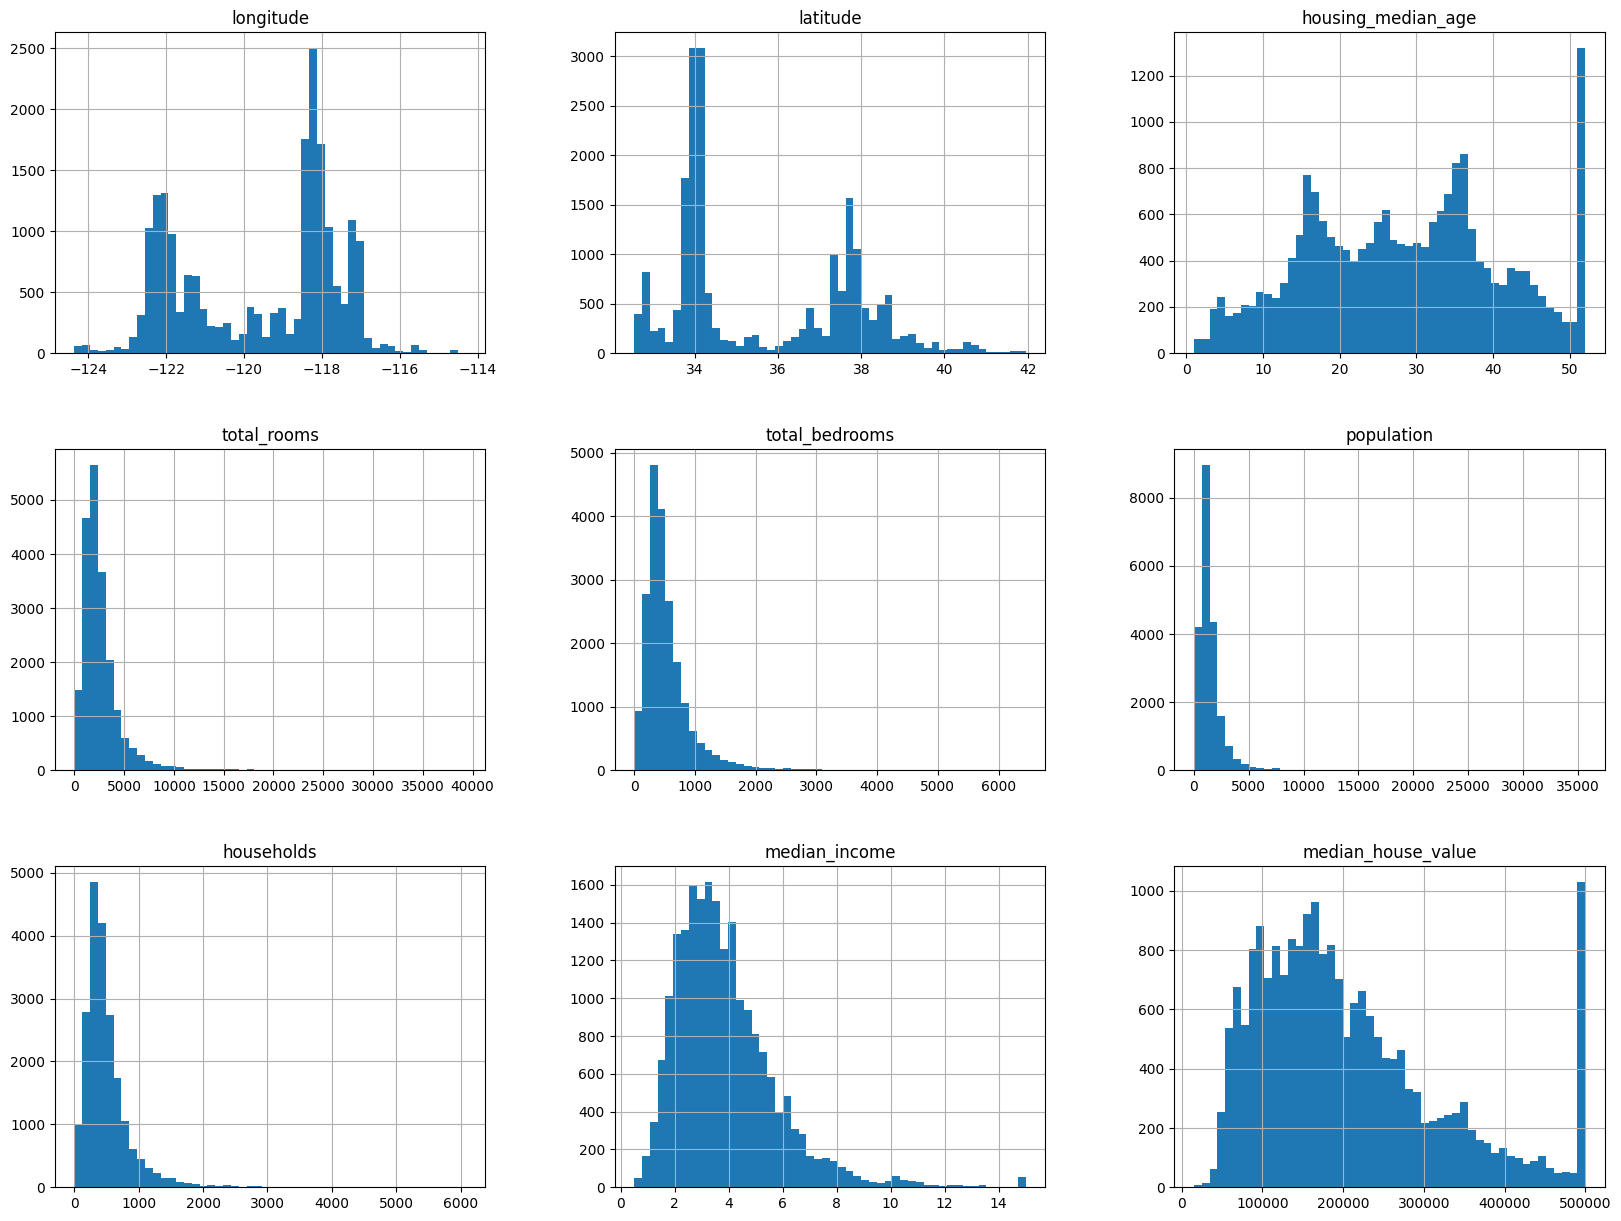

In [9]:
data.hist(bins=50, figsize=(20,15))
plt.show()

# Training and test sets

In [10]:
# first option to split data set on training/test sets
# but it's not good when data set will be updated and we receive new test set
def shuffle_and_split_data(data, test_ratio):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = shuffle_and_split_data(data, 0.2)

print("Length of the whole data set: %d" % len(data))
print("Length of the train set: %d" % len(train_set))
print("Length of the test set: %d" % len(test_set))

Length of the whole data set: 20640
Length of the train set: 16512
Length of the test set: 4128


In [11]:
# another option (to have stable train/test split) is to use each instance's identifier
# to decided whether or not it should go in the test set
def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) > test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_:is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

data_with_id = data.reset_index() # add index column
train_set, test_set = split_data_with_id_hash(data_with_id, 0.2, "index")
print("Length of the train set: %d" % len(train_set))
print("Length of the test set: %d" % len(test_set))


Length of the train set: 4128
Length of the test set: 16512


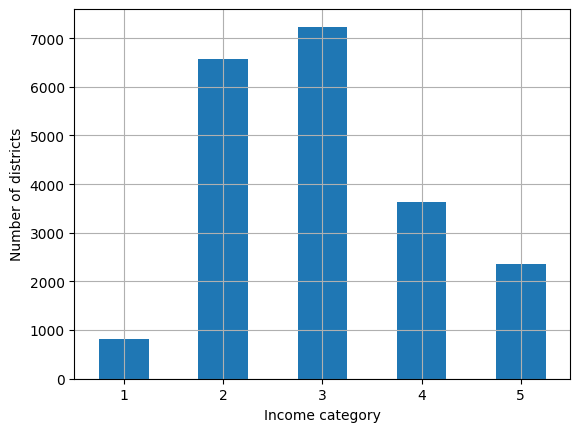

In [12]:
# Make new feature of income categories that will be used for stratified sampling
data["income_categories"] = pd.cut(data["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

data["income_categories"].value_counts().sort_index().plot.bar(rot=0,grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [13]:
# sklearn.model_selection package has various strategioes to split dataset into trainin/test set.
# every splitter has a split() function 
splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42) # make 10 splits with 20% for the test set
strat_splits = [] # will be have 10 splits where every split has 2 lists (training set indices and test set indices)
for train_index, test_index in splitter.split(data, data["income_categories"]):
    strat_train_set_n = data.iloc[train_index]
    strat_test_set_n = data.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

print(type(strat_splits))
print(type(strat_splits[0]))

strat_train_set, strat_test_set = strat_splits[0]

<class 'list'>
<class 'list'>


### Sklearn train_test_split is what I need

In [14]:
# alternative way using sklearn train_test_split
strat_train_set, strat_test_set = train_test_split(data, test_size=0.2, stratify=data["income_categories"], random_state=42)

print(len(strat_train_set))
print(len(strat_test_set))

16512
4128


In [15]:
strat_test_set["income_categories"].value_counts() / len(strat_test_set)

income_categories
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [16]:
# drop income_categories column
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_categories", axis=1, inplace=True)

In [17]:
print(strat_train_set.columns)

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')


<Axes: xlabel='longitude', ylabel='latitude'>

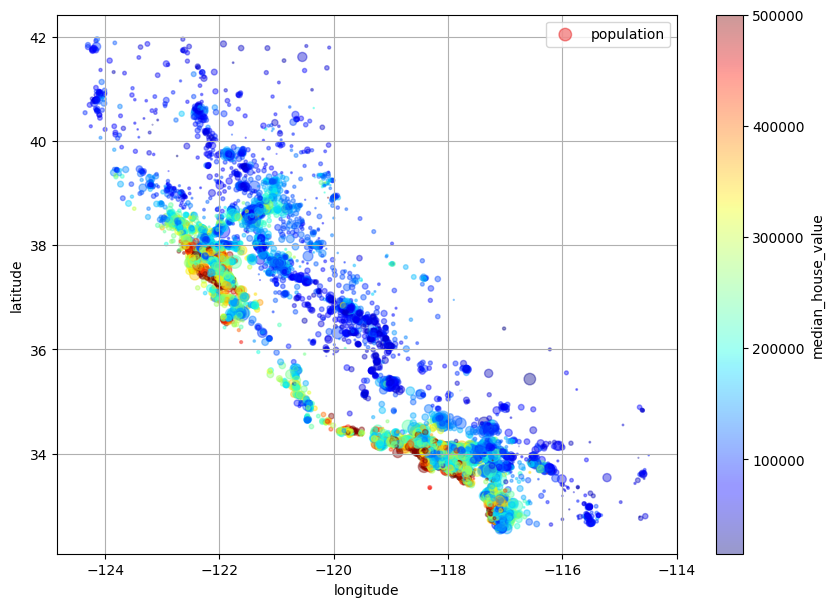

In [18]:
# Next step - discover and visualize the Data
data = strat_train_set.copy()
data.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
          s=data["population"] / 100, label="population", figsize=(10,7),
          c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True, grid=True)


In [19]:
# Looking for Correlations between features using strandard correlation coefficient
# corr_matrix = data.corr()
data_num = data.select_dtypes(include=[np.number]) # separate numerical features
corr_matrix = data_num.corr()
print(corr_matrix)

                    longitude  latitude  housing_median_age  total_rooms  \
longitude            1.000000 -0.924213           -0.102937     0.044558   
latitude            -0.924213  1.000000            0.005692    -0.036753   
housing_median_age  -0.102937  0.005692            1.000000    -0.361710   
total_rooms          0.044558 -0.036753           -0.361710     1.000000   
total_bedrooms       0.068210 -0.066391           -0.317978     0.930076   
population           0.104236 -0.115677           -0.301906     0.863967   
households           0.054261 -0.071604           -0.300075     0.916143   
median_income       -0.016542 -0.078137           -0.127043     0.197720   
median_house_value  -0.050859 -0.139584            0.102175     0.137455   

                    total_bedrooms  population  households  median_income  \
longitude                 0.068210    0.104236    0.054261      -0.016542   
latitude                 -0.066391   -0.115677   -0.071604      -0.078137   
housing_

In [20]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

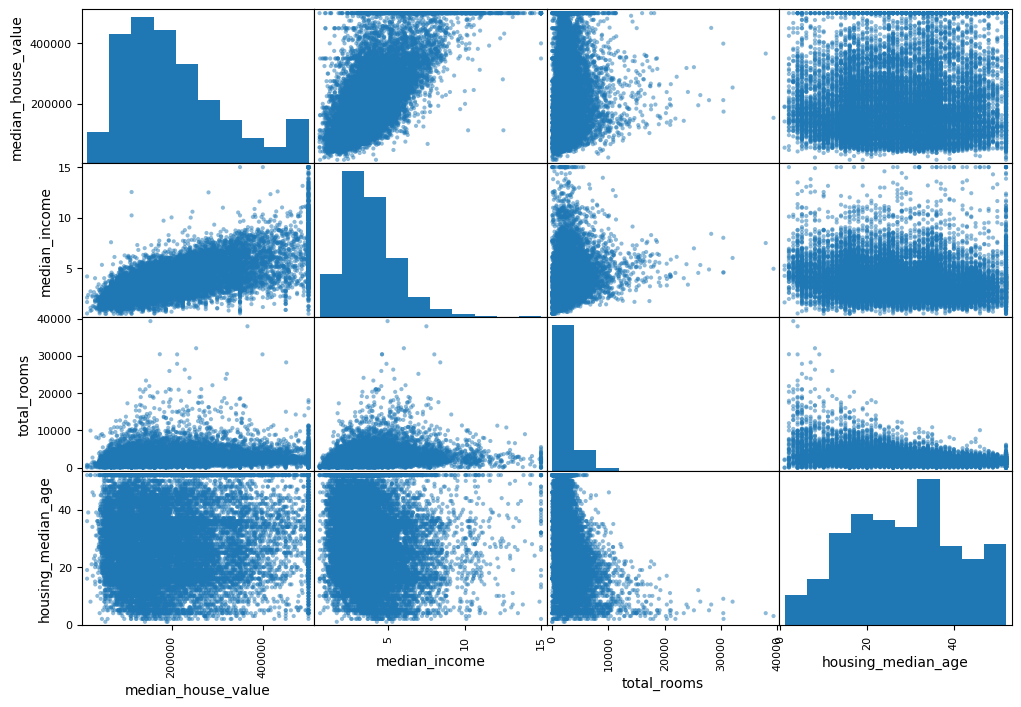

In [21]:
# We can also find correlation using Pandas scatter matrix for every pair of numerical attribute
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
pd.plotting.scatter_matrix(data[attributes], figsize=(12,8))
plt.show()

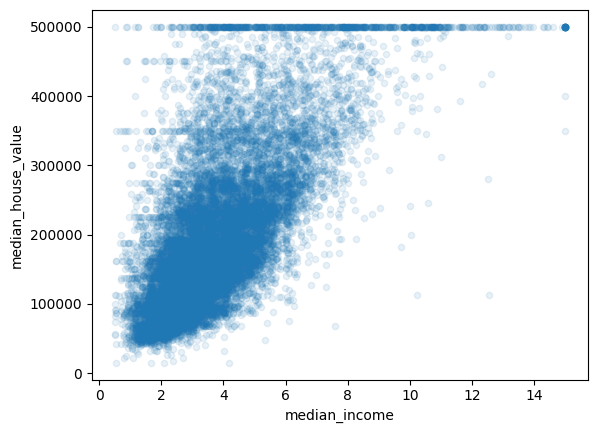

In [22]:
data.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
plt.show()

In [23]:
# Creating new attributes
data["rooms_per_household"] = data["total_rooms"] / data["households"]
data["bedrooms_per_room"] = data["total_bedrooms"] / data["total_rooms"]
data["population_per_household"] = data["population"] / data["households"]

In [24]:
data_num = data.select_dtypes(include=[np.number])
corr_matrix = data_num.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688380
rooms_per_household         0.143663
total_rooms                 0.137455
housing_median_age          0.102175
households                  0.071426
total_bedrooms              0.054635
population                 -0.020153
population_per_household   -0.038224
longitude                  -0.050859
latitude                   -0.139584
bedrooms_per_room          -0.256397
Name: median_house_value, dtype: float64

# Data preparation

In [25]:
data = strat_train_set.drop("median_house_value", axis=1) # remove target attribute
data_labels = strat_train_set["median_house_value"].copy() # make separate list of target values

We need to process attributes with empty values in three ways:
1. Get rid of the corresponding instances (DataFrame's doropna() func)
2. Get rid of the whole attribute (DataFrame's drop() func)
3. Set the values to some value (zero, the mean, the median, etc.)

Also, there is Scikit-Learn handy class to take care of missing values.

In [26]:
imputer = SimpleImputer(strategy="median") # only for numerical attributes

data_num = data.drop("ocean_proximity", axis=1)

imputer.fit(data_num)

imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [27]:
data_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [28]:
X = imputer.transform(data_num) # np array of arrays

data_tr = pd.DataFrame(X, columns=data_num.columns, index=data_num.index) # convert to DataFrame

Also, we can use fit_transform function to make the same estimation/transformation, but faster

In [29]:
data_tr.info() # let's see transformed info

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 13096 to 19888
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


##### Handle Text and Categorial Attributes

In [30]:
data_categorial = data[["ocean_proximity"]]
data_categorial.head(10)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY
18031,<1H OCEAN
6753,<1H OCEAN


In [31]:
# convert to numerical values
ordinal_encoder = OrdinalEncoder()
data_cat_encoded = ordinal_encoder.fit_transform(data_categorial)
data_cat_encoded[:10]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.],
       [0.],
       [0.]])

In [32]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Good practice is to make one hot encoding for the categorial attributes with binary attribute per category.
For example, we have thre categories. So , we will have three new binary attributes corresponded to category per row.

In [33]:
one_hot_encoder = OneHotEncoder()
data_cat_1hot = one_hot_encoder.fit_transform(data_categorial)
type(data_cat_1hot)

# we can convert scipy matrix to np.array using toarray() function

scipy.sparse._csr.csr_matrix

### Feature scaling
Two comon ways to scale:
1. min-max scaling (normalization) // scikit-learn's MinMaxScaler
2. standardization // scikit-learn's StandardScaler

### Transformation Pipeline
For more convenient data transformation we can use pipelines:

In [34]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    # ('attribs_adder', CombinedAttributesAdder()) where CombinedAttributesAdder can be custom transformer
    ('std_scaler', StandardScaler())
])

# then can use this pipeline like this
data_num_prepared = num_pipeline.fit_transform(data_num)
data_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

In [35]:
num_attribs = list(data_num)
cat_attribs = ["ocean_proximity"]

print(num_attribs)

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']


#### Column tranformer
It is useful when we transform not only numerical data.
Also, every tuple must have list of column names (third argument) that will be affected.

In [36]:
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

data_prepared = full_pipeline.fit_transform(data)

In [37]:
data_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94,  0.  ,
         0.  ,  0.  ,  1.  ,  0.  ],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17,  1.  ,
         0.  ,  0.  ,  0.  ,  0.  ]])

# Select and Train a Model

##### Linear regression model

In [38]:
lin_reg = LinearRegression()
lin_reg.fit(data_prepared, data_labels)

LinearRegression()

In [39]:
some_data = data.iloc[:5]

some_labels = data_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions: ", lin_reg.predict(some_data_prepared))
print("Labels: ", list(some_labels))

Predictions:  [270886.93228264 334830.60618945 119856.18008898 109210.92995275
 305575.65811433]
Labels:  [458300.0, 483800.0, 101700.0, 96100.0, 361800.0]


In [40]:
# Let's see RMSE (root mean squared error)
data_predictions = lin_reg.predict(data_prepared)
lin_mse = mean_squared_error(data_labels, data_predictions)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

68232.83515124217


##### Decision Tree model

In [41]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(data_prepared, data_labels)

DecisionTreeRegressor()

In [42]:
data_predictions = tree_reg.predict(data_prepared)
tree_mse = mean_squared_error(data_labels, data_predictions)
tree_rmse = np.sqrt(tree_mse)
print(tree_rmse)

0.0


##### Evaluation using Cross-Validation
Use K-fold cross validation, where we splits trainning set into 10 subsets (folds) and make 10 trains + evaluations using 9 sebset for training and tenth subset as validation and generate scores for them.

Note: cross_val_score using utility scoring function (greater is better) rather than a cost function (lower is better). That is why we use opposite to MSE - neg_mean_squared_error.

In [43]:
scores = cross_val_score(tree_reg, data_prepared, data_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [44]:
def display_score(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard deviation: ", scores.std())

display_score(tree_rmse_scores)

Scores:  [65957.56462054 66415.94136833 66487.41772398 71441.3100362
 68106.64113708 69038.17595083 70924.45270028 67809.8620881
 67462.01382845 66684.16230473]
Mean:  68032.75417585237
Standard deviation:  1802.7532053562625


In [45]:
lin_scores = cross_val_score(lin_reg, data_prepared, data_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores =  np.sqrt(-lin_scores)
display_score(lin_rmse_scores)

Scores:  [69823.93458835 67748.84358734 67256.04927007 69050.18214272
 67334.60772112 68688.9649581  67424.75877757 69952.42288885
 67537.81218643 68344.1931601 ]
Mean:  68316.17692806528
Standard deviation:  971.5373052470941


# Random Forest Regression model

In [46]:
forest_reg = RandomForestRegressor()
forest_reg.fit(data_prepared, data_labels) # train

# Predict on the training set
data_predictions = forest_reg.predict(data_prepared)
forest_mse = mean_squared_error(data_labels, data_predictions)
forest_rmse = np.sqrt(forest_mse)
print(forest_rmse)

18177.093729132997


In [47]:
# Train and predict using validation set
forest_scores = cross_val_score(forest_reg, data_prepared, data_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_score(forest_rmse_scores)

Scores:  [48422.23720365 49609.67069024 46839.44869407 49389.78386815
 48517.97001188 49375.26328691 48701.95375304 49718.78505929
 48968.92638167 48898.39289793]
Mean:  48844.24318468284
Standard deviation:  792.0080995374656


It's a good practice to save trained model for future usage if we will decide to switch bteween differen models.
Saving models using joblib library is efficient way to serialize large np arrays.

# Fine-Tune Model

### Grid Search

In [52]:
params_grid = [
    {'n_estimators': [3, 10, 30, 100], 'max_features': [2, 4, 6, 8]},
    {'n_estimators': [3, 10], 'max_features': [3, 10], 'bootstrap': [False]}
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, params_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(data_prepared, data_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30, 100]},
                         {'bootstrap': [False], 'max_features': [3, 10],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [57]:
print("Best estimator: ", grid_search.best_estimator_)
print("Best params: ", grid_search.best_params_)

Best estimator:  RandomForestRegressor(max_features=8)
Best params:  {'max_features': 8, 'n_estimators': 100}


In [58]:
# evalutation scores
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63137.80707293749 {'max_features': 2, 'n_estimators': 3}
54975.719481257955 {'max_features': 2, 'n_estimators': 10}
52014.56094558817 {'max_features': 2, 'n_estimators': 30}
51064.46457727633 {'max_features': 2, 'n_estimators': 100}
60064.9550286346 {'max_features': 4, 'n_estimators': 3}
52045.59132985085 {'max_features': 4, 'n_estimators': 10}
50074.89059375588 {'max_features': 4, 'n_estimators': 30}
49262.17508316114 {'max_features': 4, 'n_estimators': 100}
57209.695722466895 {'max_features': 6, 'n_estimators': 3}
51382.54398520035 {'max_features': 6, 'n_estimators': 10}
49642.29738081758 {'max_features': 6, 'n_estimators': 30}
48931.208706542886 {'max_features': 6, 'n_estimators': 100}
58513.14385742102 {'max_features': 8, 'n_estimators': 3}
51873.89921346529 {'max_features': 8, 'n_estimators': 10}
49625.12608863418 {'max_features': 8, 'n_estimators': 30}
48790.29783922414 {'max_features': 8, 'n_estimators': 100}
59022.26750741494 {'bootstrap': False, 'max_features': 3, 'n_estimator

Feature importance

In [60]:
feature_importance = grid_search.best_estimator_.feature_importances_

extra_attribs = ["rooms_per_household", "population_per_household", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_1hot_attributes = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_1hot_attributes

sorted(zip(feature_importance, attributes), reverse=True)

[(0.44163811061999386, 'median_income'),
 (0.1486069884796766, 'population_per_household'),
 (0.11756982784733626, 'longitude'),
 (0.10515655315283161, 'latitude'),
 (0.047352724649630876, 'housing_median_age'),
 (0.03708761854096644, 'population'),
 (0.029847435558408603, 'total_rooms'),
 (0.02603350199473337, 'total_bedrooms'),
 (0.024502700461203734, 'households'),
 (0.013304043014214449, 'rooms_per_household'),
 (0.00663529577732075, 'INLAND'),
 (0.001958695734283059, '<1H OCEAN'),
 (0.00030650416940022695, 'bedrooms_per_room')]

# Evaluate system on the Test Set

In [62]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print(final_rmse)

48967.41833103588


In [64]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

array([46591.52260207, 51233.25226485])

In [65]:
joblib.dump(final_model, "housing_model.pkl")

['housing_model.pkl']